In [1]:
import pandas as pd

import time
import datetime

import pygal
from pygal.style import Style
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

import gmaps
import gmaps.datasets

import pickle

from nltk.tokenize.casual import TweetTokenizer

In [2]:
tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return tknzr.tokenize(msg)

def remove_retweet(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http'), msg.split()))

In [3]:
def date_distribution(X, date_from, date_to, step = 'day', day_count = 1, by_blocks = False):
    neg = X[X['ttype'] == NEG_TWEET]
    pos = X[X['ttype'] == POS_TWEET]
    
    neg_date = neg[neg['tdate'] < date_to]
    pos_date = pos[pos['tdate'] < date_to]
    
    if step == 'minute':
        step = 60
    elif step == 'hour':
        step = 60*60
    elif step == 'day':
        step = 60*60*24*day_count
    elif step == 'week':
        step = 60*60*24*7
    
    pos_count = list()
    neg_count = list()
    
    dates_in_range = range(date_from, date_to, step)
    
    for date in dates_in_range:
        if by_blocks:
            pos_count.append(pos_date[(pos_date['tdate'] > date) & (pos_date['tdate'] < (date + step))].shape[0])
            neg_count.append(neg_date[(neg_date['tdate'] > date) & (neg_date['tdate'] < (date + step))].shape[0])
        else:
            pos_count.append(pos_date[pos_date['tdate'] < date].shape[0])
            neg_count.append(neg_date[neg_date['tdate'] < date].shape[0])
            
    
    dates_in_range = [datetime.datetime.fromtimestamp(d) for d in dates_in_range]
    return pos_count, neg_count, dates_in_range
    
def split_points(pnt):
    return tuple(map(float, pnt.split(','))) 

In [4]:
with open('maps_token.txt') as f:
    key = f.read()
    gmaps.configure(api_key=key)
    
NEG_TWEET = -1
POS_TWEET = 1

FIG_SIZE = (15, 6)

## Визуализация тренировочных твитов
Визуализируются следующие параметры:
* Сколько всего негативных и позитивных твитов от даты А до даты Б
* Сколько было позитивных/негативных твитов от даты А до даты Б по "блокам" (например, недели)

Даты в исходном датасете распределены неравномерно.

In [5]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'trep', 'tmane', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'trep', 'tmane', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)


X = pd.concat([pos, neg], ignore_index=True)

/home/vladka/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


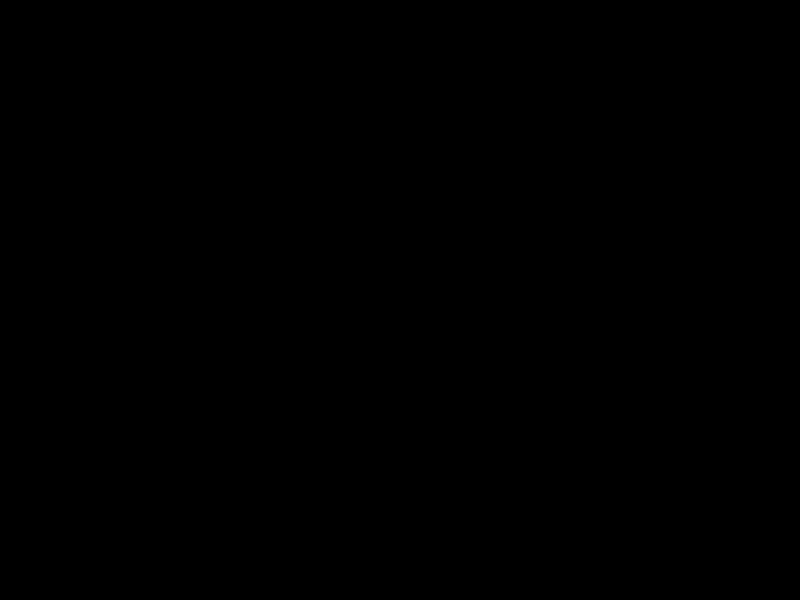

In [6]:
pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(),
                                                step = 'week', by_blocks = True)

dates = [d.strftime('%Y-%m-%d') for d in dates]

line_chart = pygal.Bar(style=Style(colors=('green', 'red')))
line_chart.x_labels = dates

line_chart.add('Positive', pos_count)
line_chart.add('Negative', neg_count)

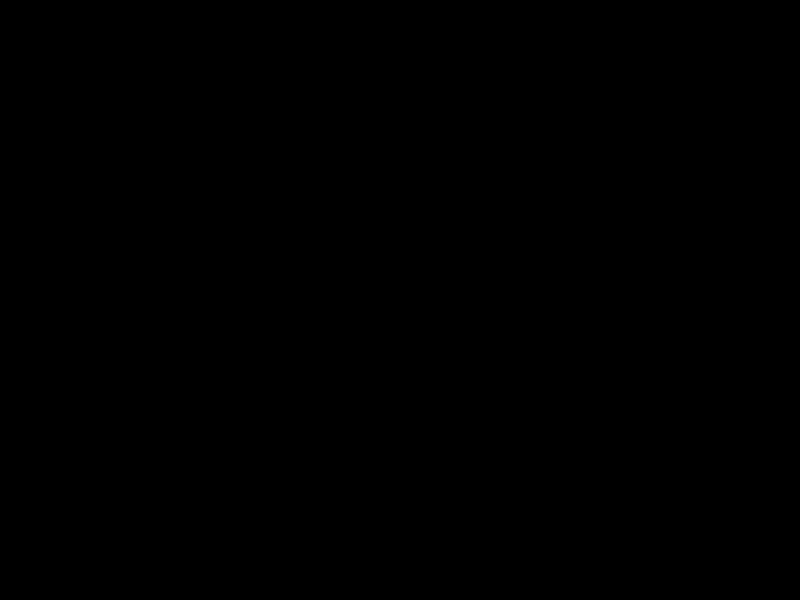

In [7]:
pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(), step = 'day')

datetimeline = pygal.DateTimeLine(
    x_label_rotation=35, truncate_label=-1,
    x_value_formatter=lambda dt: dt.strftime('%Y-%m-%d'),
    style=Style(colors=('green', 'red')))

datetimeline.add('Positive', zip(dates, pos_count))
datetimeline.add('Negative', zip(dates, neg_count))

## Визуализация твитов по ВУЗ'ам
Heatmap твитов, процент твитов с геотэгами маленький (примерно 1 твит на 50), поэтому карта не очень полно выглядит.
Необходимо авторизоваться т.к. используются google maps. API key для JS google maps API загружается из файла maps_token.txt

In [8]:
def get_heatmap(X):
    if X.shape[0] != 0:
        points = list(Tweets['tgeo'].apply(split_points))

        m = gmaps.Map()
        m.add_layer(gmaps.Heatmap(data=points))
        return m
    else:
        print 'There is no tweets with geotag!'

In [9]:
Tweets = pd.read_csv('data/old_tweets/MSU.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

In [10]:
Tweets = pd.read_csv('data/old_tweets/MIPT.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

In [11]:
Tweets = pd.read_csv('data/old_tweets/SPBU.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

There is no tweets with geotag!


In [12]:
Tweets = pd.read_csv('data/old_tweets/ITMO.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

## Графики твитов по ВУЗ'ам
Визуализируются следующие параметры:
* Сколько всего негативных и позитивных твитов от даты А до даты Б
* Сколько было позитивных/негативных твитов от даты А до даты Б по "блокам" (например, недели)

Для начала необходимо классифицировать твиты т.к. изначально у них нет меток.

In [13]:
def str_to_timestamp(date):
    return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()))

In [14]:
with open('models/model_sgd.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)  

In [31]:
universities = ['MIPT', 'ITMO', 'SPBU']

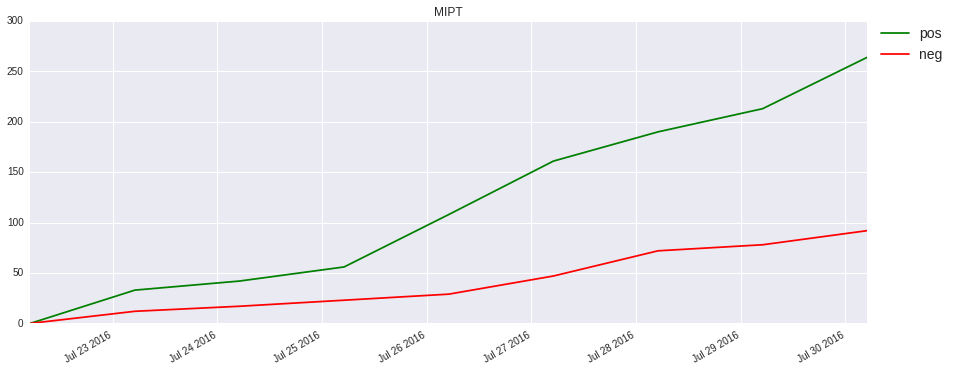

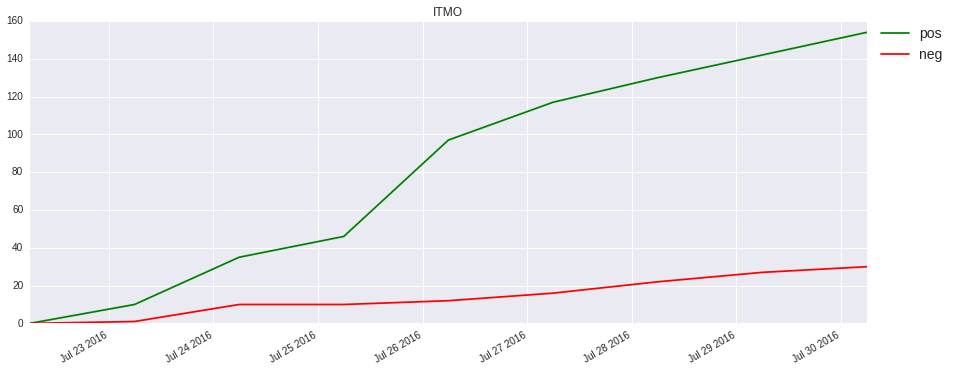

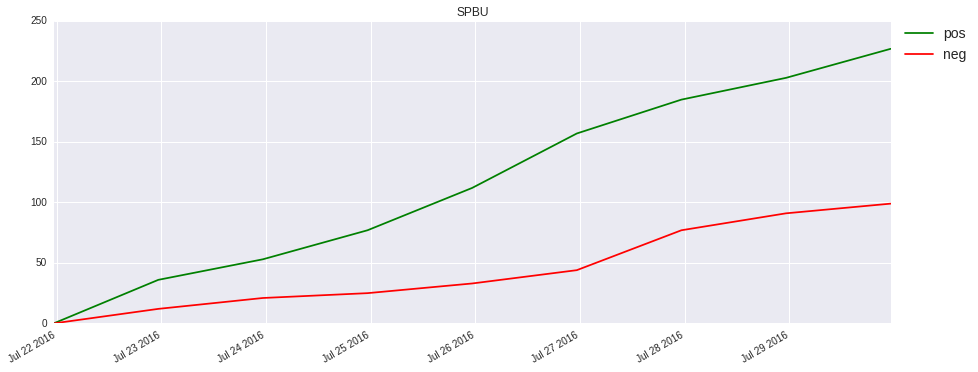

In [32]:
for u in universities:
    X = pd.read_csv('data/old_tweets/' + u + '.csv', sep = ';')
    X['tdate'] = X['tdate'].apply(lambda x: int(time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple())))
    X['ttext'] = X['ttext'].apply(remove_retweet)
    X['ttype'] = model.predict(vectorizer.transform(X['ttext']))

    pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(), step = 'day')
    
    dates = date2num(dates)

    fig, ax = plt.subplots()
    fig.set_size_inches(FIG_SIZE)

    plt.plot(dates, pos_count, color = 'green', label = 'pos')
    plt.plot(dates, neg_count, color = 'red', label = 'neg')

    ax.xaxis_date()
    plt.gcf().autofmt_xdate()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad = 0., fontsize=14)

    ax.autoscale_view(False, True)

    plt.title(u)

IOError: File data/old_tweets/MSU.csv does not exist

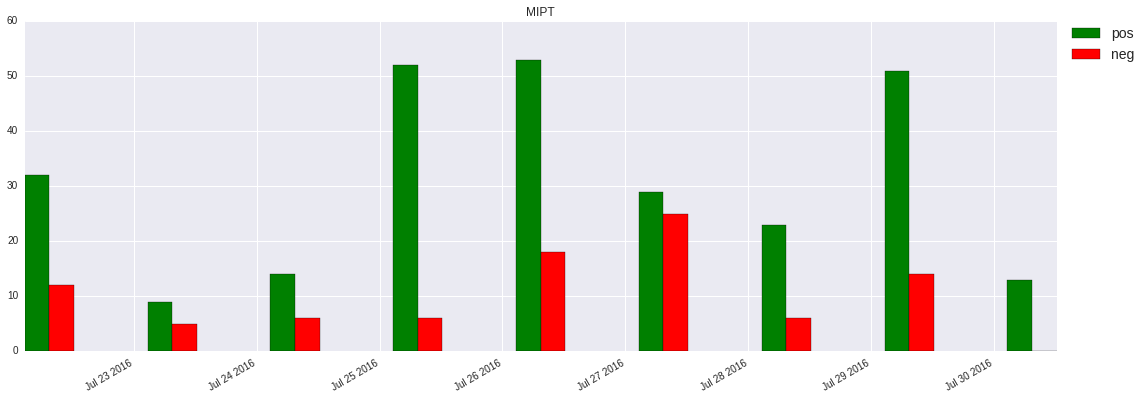

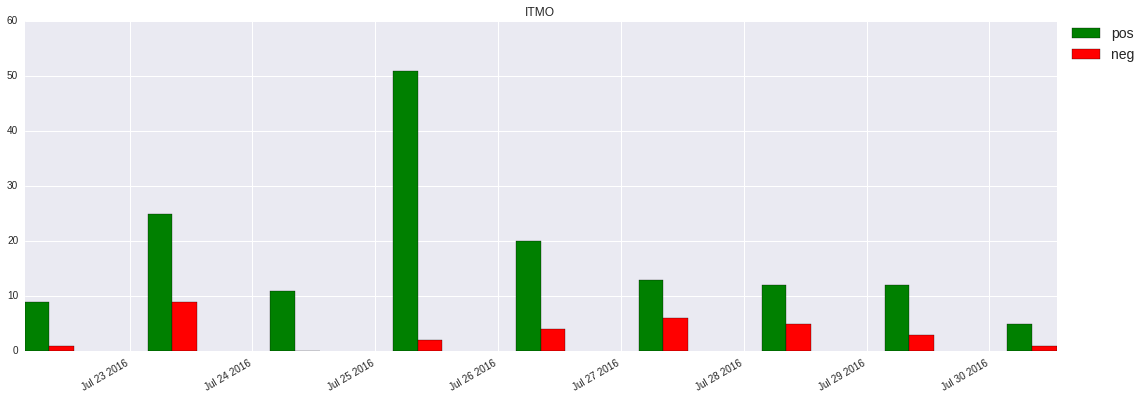

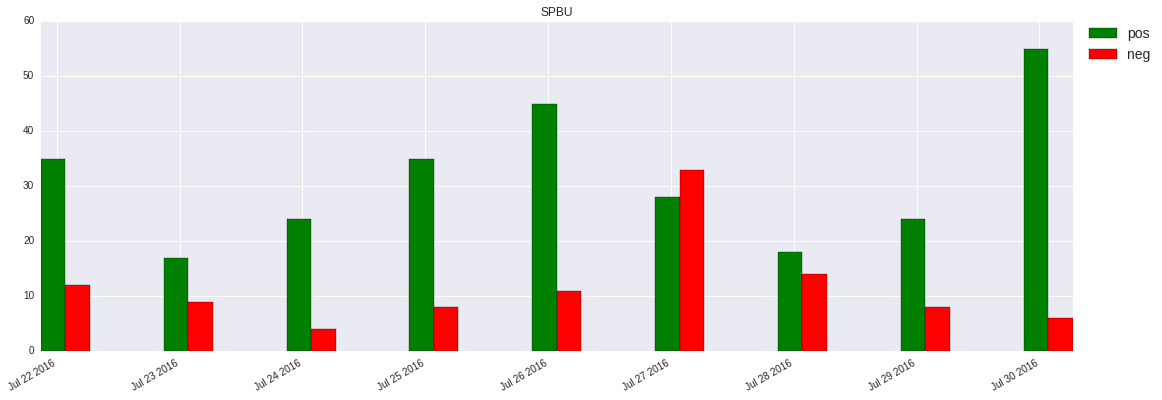

In [30]:
for u in universities:
    X = pd.read_csv('data/old_tweets/' + u + '.csv', sep = ';')
    X['tdate'] = X['tdate'].apply(str_to_timestamp)
    X['ttext'] = X['ttext'].apply(remove_retweet)
    X['ttype'] = model.predict(vectorizer.transform(X['ttext']))

    pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(),
                                                    step = 'day', by_blocks = True)
    dates = date2num(dates)

    fig, ax = plt.subplots()
    fig.set_size_inches(FIG_SIZE)

    plt.tight_layout()

    w = 0.2
    ax.bar(dates - w/2, pos_count, width=w, color = 'green', label = 'pos')
    ax.bar(dates + w/2 , neg_count, width=w, color = 'red', label = 'neg')

    ax.xaxis_date()

    plt.gcf().autofmt_xdate()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad = 0., fontsize=14)

    ax.autoscale_view(False, True)
    plt.title(u)